# Using more sophisticated images with Convolutional Neural Networks

In the previous lesson you saw how to use a CNN to make your recognition of the handwriting digits more efficient. In this lesson you'll take that to the next level, recognizing real images of Cats and Dogs in order to classify an incoming image as one or the other. In particular the handwriting recognition made your life a little easier by having all the images be the same size and shape, and they were all monochrome color. Real-world images aren't like that -- they're in different shapes, aspect ratios etc, and they're usually in color!

So, as part of the task you need to process your data -- not least resizing it to be uniform in shape.

You'll follow these steps:

1. Explore the Example Data of Cats and Dogs
2. Build and Train a Neural Network to recognize the difference between the two
3. Evaluate the Training and Validation accuracy

In [1]:
""" Explore the dataset

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in /tmp.

NOTE: The 2,000 images used in this exercise are excerpted from the "Dogs vs. Cats" dataset available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.
"""
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-11-24 10:15:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
wget: /Users/carlos/.netrc:2: warning: ‘login’ token appears before any machine name
wget: /Users/carlos/.netrc:3: warning: ‘password’ token appears before any machine name
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.1.208, 172.217.2.16, 172.217.11.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.1.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  10.2MB/s    in 6.8s    

2020-11-24 10:15:30 (9.64 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
""" Unzip and extract

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains train and validation subdirectories for the training and validation datasets.
"""
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/tmp')

In [4]:
""" Define the Training and Validation directories """
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
""" Let's see what the filenames look like (Validation filenames have the same convention) """
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.952.jpg', 'cat.946.jpg', 'cat.6.jpg', 'cat.749.jpg', 'cat.991.jpg', 'cat.985.jpg', 'cat.775.jpg', 'cat.761.jpg', 'cat.588.jpg', 'cat.239.jpg']
['dog.775.jpg', 'dog.761.jpg', 'dog.991.jpg', 'dog.749.jpg', 'dog.985.jpg', 'dog.952.jpg', 'dog.946.jpg', 'dog.211.jpg', 'dog.577.jpg', 'dog.563.jpg']


In [6]:
""" How many images are there? """
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(validation_cats_dir)))
print('total validation dog images :', len(os.listdir(validation_dogs_dir)))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [7]:
""" Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters """
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

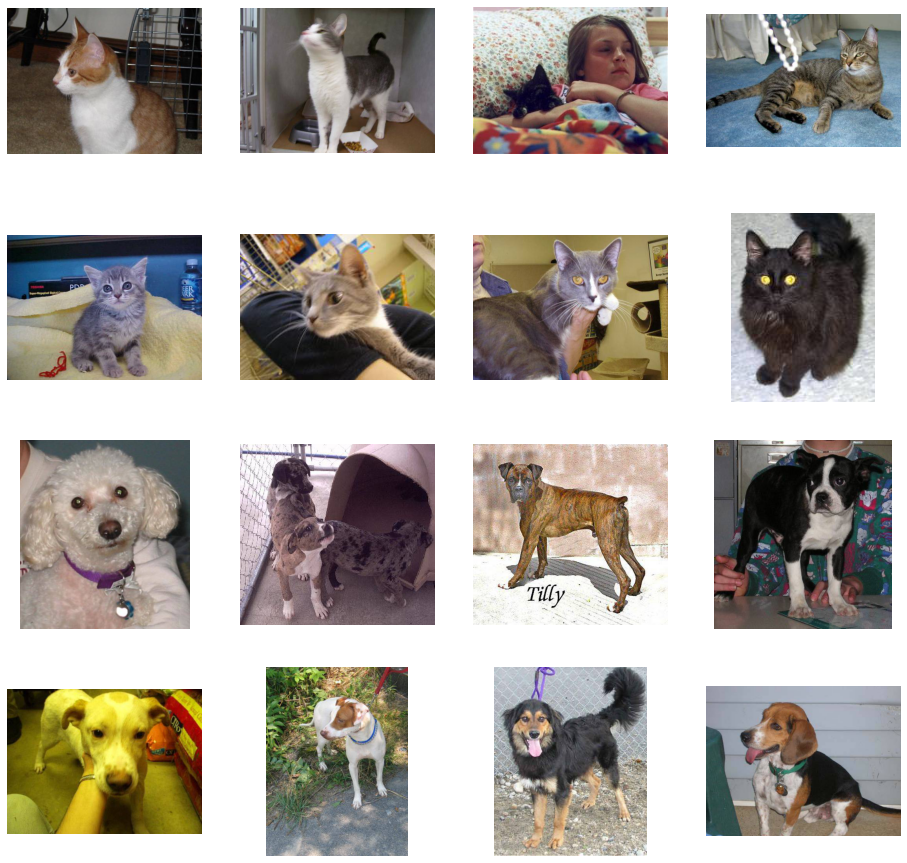

In [8]:
""" Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time: """
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch to Get to ~72% Accuracy

In the previous section you saw that the images were in a variety of shapes and sizes. In order to train a neural network to handle them you'll need them to be in a uniform size. We've chosen 150x150 for this, and you'll see the code that preprocesses the images to that shape shortly.

In [10]:
""" Define the Model """
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 is for class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [11]:
""" Compile the Model """
model.compile(
    optimizer=tf.optimizers.RMSprop(learning_rate=0.001),
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [12]:
""" Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit, evaluate_generator, and predict_generator.
"""
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen  = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150, 150)
)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size=20,
    class_mode  = 'binary',
    target_size = (150, 150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
""" Training

Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 test images. (This may take a few minutes to run.)

* Do note the values per epoch.
* You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result.

* Accuracy is the portion of correct guesses.
* The Validation accuracy is the measurement with the data that has not been used in training.

As expected this would be a bit lower. You'll learn about why this occurs in the section on overfitting later in this course.
"""
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_steps=50,
    verbose=2
)

Epoch 1/15
100/100 - 17s - loss: 0.7671 - accuracy: 0.5750 - val_loss: 0.6412 - val_accuracy: 0.6160
Epoch 2/15
100/100 - 17s - loss: 0.6254 - accuracy: 0.6780 - val_loss: 0.6027 - val_accuracy: 0.6800
Epoch 3/15
100/100 - 17s - loss: 0.5192 - accuracy: 0.7420 - val_loss: 0.5946 - val_accuracy: 0.7050
Epoch 4/15
100/100 - 17s - loss: 0.4488 - accuracy: 0.8035 - val_loss: 0.5609 - val_accuracy: 0.7060
Epoch 5/15
100/100 - 17s - loss: 0.3539 - accuracy: 0.8460 - val_loss: 0.6330 - val_accuracy: 0.7220
Epoch 6/15
100/100 - 17s - loss: 0.2792 - accuracy: 0.8880 - val_loss: 0.6625 - val_accuracy: 0.7270
Epoch 7/15
100/100 - 16s - loss: 0.1891 - accuracy: 0.9220 - val_loss: 0.7308 - val_accuracy: 0.7140
Epoch 8/15
100/100 - 17s - loss: 0.1448 - accuracy: 0.9420 - val_loss: 0.8908 - val_accuracy: 0.7340
Epoch 9/15
100/100 - 16s - loss: 0.0966 - accuracy: 0.9640 - val_loss: 1.2756 - val_accuracy: 0.7000
Epoch 10/15
100/100 - 17s - loss: 0.0972 - accuracy: 0.9730 - val_loss: 1.3259 - val_accura

In [14]:
""" Running the Model

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a dog or a cat.

* Current code only works in Google Colab
"""
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
    # predicting images
    path='/content/' + fn
    img=image.load_img(path, target_size=(150, 150))
    
    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
    
    classes = model.predict(images, batch_size=10)
    
    print(classes[0])
    
    if classes[0] > 0:
      print(fn + " is a dog")
    else:
      print(fn + " is a cat")
 

ModuleNotFoundError: No module named 'google.colab'

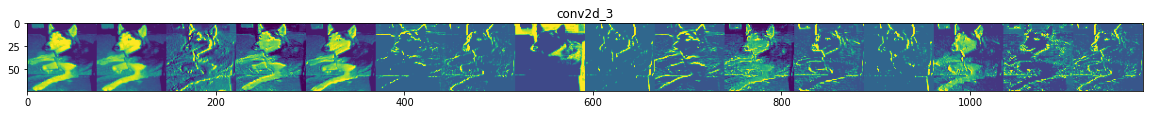

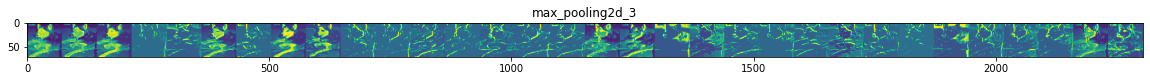

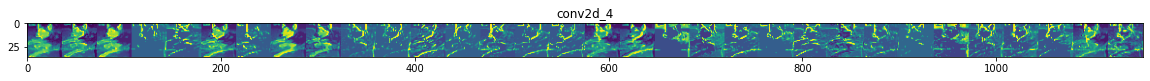

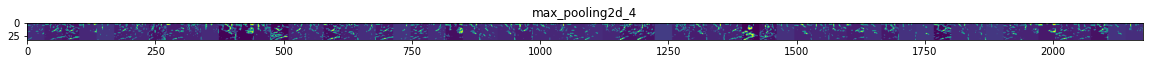

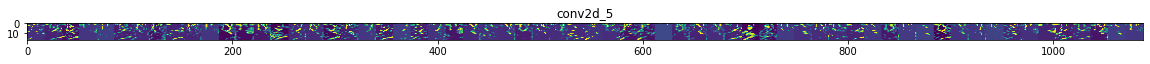

In [15]:
""" Visualize Intermediate Representations """
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

Text(0.5, 1.0, 'Training and validation loss')

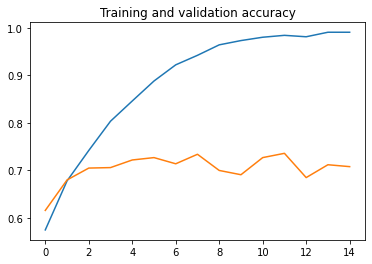

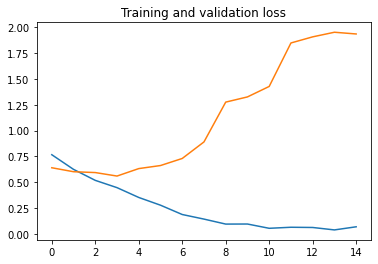

In [19]:
""" Evaluating Accuracy and Loss for the Model with a Visualization """
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

## Overfitting

As you can see, we are **overfitting**. Our training accuracy (in blue) get close to 100% while our validation accuracy (in orange) stalls.
Our validation loss reaches its minimum after only five epochs...

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern.

> Overfitting happens when a model exposed to too few examples learns patterns that do not `generalize` to new data.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of ourm odel to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?